
# Introduction to Regression.

    Author: Jerónimo Arenas García (jarenas@tsc.uc3m.es)
            Jesús Cid Sueiro (jcid@tsc.uc3m.es)

    Notebook version: 1.2 (Sep 14, 2024)

    Changes: v.1.0 - First version. Extracted from regression_intro_knn v.1.0.
             v.1.1 - (JCS) Compatibility with python 2 and python 3
             v.1.2 - (JCS) Removed compatiblity with python 2. Improved text. Concept of generalization.

In [1]:
# Import some libraries that will be necessary for working with data and displaying plots

# To visualize plots in the notebook
%matplotlib inline 

import numpy as np
import pandas as pd   # To read data tables from csv files

# For plots and graphical results
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D   
import pylab

# That's default image size for this interactive session
pylab.rcParams['figure.figsize'] = 9, 6  


## 1. The regression problem

The goal of regression methods is to predict the value of some *target* variable $S$ from the observation of variables that we will collect in a single vector $\bf X$).

Regression problems arise in situations where the value of the target variable is not easily accessible, but we can measure other dependent variables, from which we can try to predict $S$.  

<p align="center">
<img src="figs/block_diagram.png" width=400>
</p>








The only information available to estimate the relation between the inputs and the target is a *dataset* $\mathcal D$ containing several observations of all variables.

$$\mathcal{D} = \{{\bf x}_{k}, s_{k}\}_{k=0}^{K-1}$$

The dataset $\mathcal{D}$ must be used to find a function $f$ that, for any observation vector ${\bf x}$, computes an output $\hat{s} = f({\bf x})$ that is a good predition of the true value of the target, $s$.

<p align="center">
  <img src="figs/predictor.png" width=300>
</p>

## 2. Examples of regression problems.

The <a href=http://scikit-learn.org/>scikit-learn</a> package contains several <a href=https://scikit-learn.org/stable/datasets.html> datasets</a> related to regression problems. 

* **Boston dataset**: the target variable contains housing values in different suburbs of Boston. The goal is to predict these values based on several social, economic and demographic variables taken frome theses suburbs. (Dataset no longer available in sklearn).
* <a href=http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes /> Diabetes dataset</a>.
* **California housing**.


We can load these datasets as follows:

In [20]:
# Boston dataset
# data_url = "http://lib.stat.cmu.edu/datasets/boston"
# raw_df = pd.read_csv(data_url, sep="\\s+", skiprows=22, header=None)
# X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
# S = raw_df.values[1::2, 2]
# n_samples = X.shape[0]  # Number of observations
# n_vars = X.shape[1]     # Number of variables (including input and target)

# feature_names = [f'feature $x_{{{i}}}$' for i in range(n_vars)]

In [2]:
# Alternative dataset 1: Diabetes
from sklearn import datasets
# Load the dataset. Select it by uncommenting the appropriate line
D_all = datasets.load_diabetes()

# Extract data and data parameters.
X = D_all.data         # Complete data matrix (including input and target variables)
S = D_all.target      # Target variables

n_samples = X.shape[0]  # Number of observations
n_vars = X.shape[1]     # Number of variables (including input and target)

feature_names = [f'feature {i}' for i in range(n_vars)]

In [ ]:
# Alternative dataset 2: California Housing
# from sklearn.datasets import fetch_california_housing
# housing = fetch_california_housing()

# Extract data and data parameters.
# X = housing.data         # Complete data matrix (including input and target variables)
# S = housing.target      # Target variables
# info = housing.DESCR
# feature_names = housing.feature_names
# print(info)

In [3]:
n_samples = X.shape[0] # Number of observations
n_vars = X.shape[1]    # Number of variables (including input and target)

This dataset contains 

In [4]:
print(n_samples)

442


observations of the target variable and

In [5]:
print(n_vars)

10


input variables.

## 3. Scatter plots

### 3.1. 2D scatter plots

When the instances of the dataset are multidimensional, they cannot be visualized directly, but we can get a first rough idea about the regression task if we plot the target variable versus one of the input variables. These representations are known as <i>scatter plots</i>

Python methods `plot` and `scatter` from the `matplotlib` package can be used for these graphical representations. 

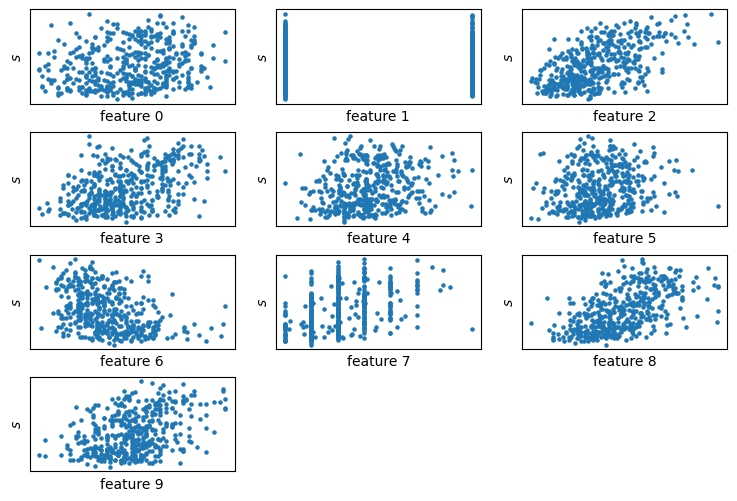

In [6]:
# Select a dataset
nrows = 4
ncols = 1 + (X.shape[1]-1) // nrows

# Some adjustment for the subplot.
pylab.subplots_adjust(hspace=0.3)

# Plot all variables
for idx in range(X.shape[1]):
    ax = plt.subplot(nrows, ncols, idx+1)
    ax.scatter(X[:,idx], S, s=5)    # <-- This is the key command
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    plt.xlabel(f'{feature_names[idx]}')
    plt.ylabel('$s$')

### 3.2. 3D Plots

With the addition of a third coordinate, `plot` and `scatter` can be used for 3D plotting.

##### Exercise 1:

Select the `diabetes` dataset. Visualize the target versus components 2 and 5. (You can get more info about the <a href=http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter>scatter</a> command and an <a href=http://matplotlib.org/examples/mplot3d/scatter3d_demo.html>example of use</a> in the <a href=http://matplotlib.org/index.html> matplotlib</a> documentation)

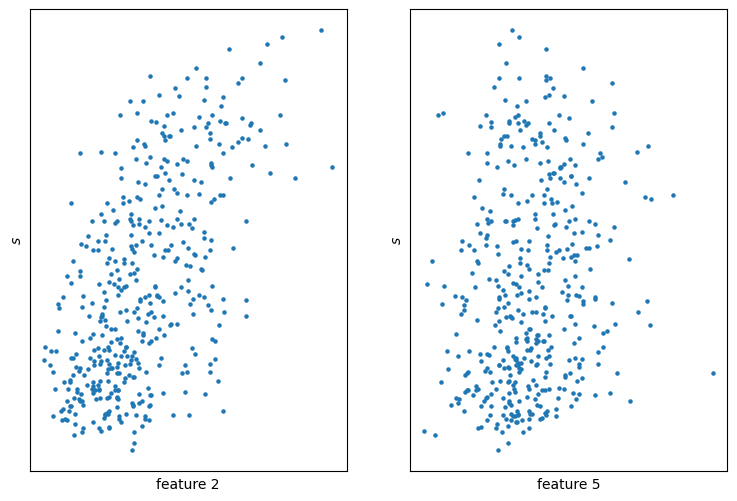

In [7]:
a = (2, 5)
i = 1
for idx in a:
    ax = plt.subplot(1, 2, i)
    ax.scatter(X[:,idx], S, s=5)    # <-- This is the key command
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    plt.xlabel(f'{feature_names[idx]}')
    plt.ylabel('$s$')
    i = i + 1


## 4. Evaluating a regression task

In order to evaluate the performance of a given predictor, we need to quantify the quality of predictions. This is usually done by means of a loss function $l(s,\hat{s})$. Two common losses are

   * Square error: $l(s, \hat{s}) = (s - \hat{s})^2$
   * Absolute error: $l(s, \hat{s}) = |s - \hat{s}|$

Note that both the square and absolute errors are functions of the estimation error $e = s-{\hat s}$. However, this is not necessarily the case. As an example, imagine a situation in which we would like to introduce a penalty which increases with the magnitude of the estimated variable. For such case, the following cost would better fit our needs: $l(s,{\hat s}) = s^2 \left(s-{\hat s}\right)^2$.

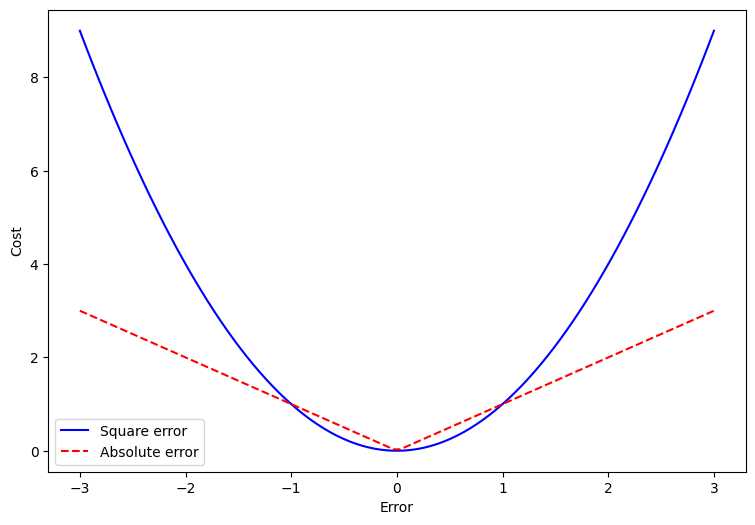

In [15]:
# In this section we will plot together the square and absolute errors
grid = np.linspace(-3,3,num=100)
plt.plot(grid, grid**2, 'b-', label='Square error')
plt.plot(grid, np.absolute(grid), 'r--', label='Absolute error')
plt.xlabel('Error')
plt.ylabel('Cost')
plt.legend(loc='best')
plt.show()

The overal prediction performance is computed as the average of the loss computed over a set of samples:

$${\bar R} = \frac{1}{K}\sum_{k=0}^{K-1} l\left(s_k, \hat{s}_k\right)$$

##### Exercise 2:

The dataset in file `'datasets/x01.csv'`, taken from <a href="http://people.sc.fsu.edu/~jburkardt/datasets/regression/x01.txt">here</a> records the average weight of the brain and body for a number of mammal species.
* Represent a scatter plot of the targe variable versus the one-dimensional input.
* Plot, over the same plot, the prediction function given by $S = 1.2 X$.
* Represent the prediction function in logarithmic scale, using <a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.loglog.html">`loglog`</a> instead of `plot`.
* Compute the square error rate for the given dataset.

[4.450e+01 1.550e+01 8.100e+00 4.230e+02 1.195e+02 1.150e+02 9.820e+01
 5.500e+00 5.800e+01 6.400e+00 4.000e+00 5.700e+00 6.600e+00 1.400e-01
 1.000e+00 1.080e+01 1.230e+01 6.300e+00 4.603e+03 3.000e-01 4.190e+02
 6.550e+02 3.500e+00 1.150e+02 2.560e+01 5.000e+00 1.750e+01 6.800e+02
 4.060e+02 3.250e+02 1.230e+01 1.320e+03 5.712e+03 3.900e+00 1.790e+02
 5.600e+01 1.700e+01 1.000e+00 4.000e-01 2.500e-01 1.250e+01 4.900e+02
 1.210e+01 1.750e+02 1.570e+02 4.400e+02 1.795e+02 2.400e+00 8.100e+01
 2.100e+01 3.920e+01 1.900e+00 1.200e+00 3.000e+00 3.300e-01 1.800e+02
 2.500e+01 1.690e+02 2.600e+00 1.140e+01 2.500e+00 5.040e+01]
x
[3.385e+00 4.800e-01 1.350e+00 4.650e+02 3.633e+01 2.766e+01 1.483e+01
 1.040e+00 4.190e+00 4.250e-01 1.010e-01 9.200e-01 1.000e+00 5.000e-03
 6.000e-02 3.500e+00 2.000e+00 1.700e+00 2.547e+03 2.300e-02 1.871e+02
 5.210e+02 7.850e-01 1.000e+01 3.300e+00 2.000e-01 1.410e+00 5.290e+02
 2.070e+02 8.500e+01 7.500e-01 6.200e+01 6.654e+03 3.500e+00 6.800e+00
 3.500e+01 4.

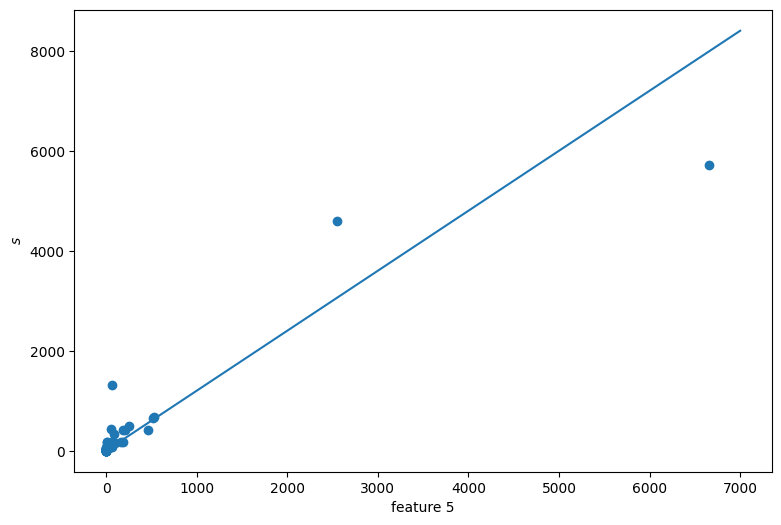

In [15]:
# Load dataset in arrays X and S
df = pd.read_csv('datasets/x01.csv', sep=',', header=None)
X = df.values[:,0]
S = df.values[:,1]

x = np.array([0,7000])
plt.scatter(X, S)    # <-- This is the key command
plt.plot(x, 1.2*x)
plt.xlabel(f'{feature_names[idx]}')
plt.ylabel('$s$')
print(S)
print('x')
print(X)

Text(0, 0.5, '$s$')

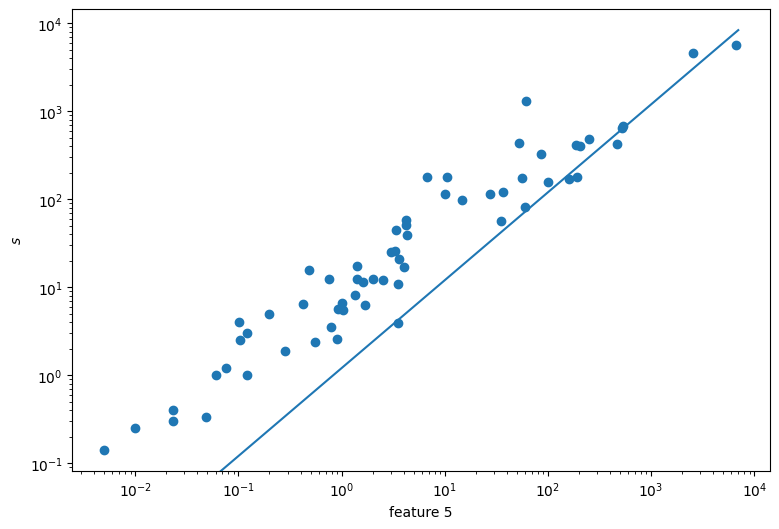

In [9]:
# Load dataset in arrays X and S
df = pd.read_csv('datasets/x01.csv', sep=',', header=None)
X = df.values[:,0]
S = df.values[:,1]

x = np.array([0,7000])
plt.scatter(X, S)    # <-- This is the key command
plt.loglog(x, 1.2*x)
plt.xlabel(f'{feature_names[idx]}')
plt.ylabel('$s$')

#Parece más acorde

In [10]:
rate = np.mean((S-1.2*X)**2)
print(rate)

153781.94388919484


### 4.1. Training and Test Data

The primary objective of a regression algorithm is to obtain a predictor that performs well on new, unseen inputs. This characteristic is typically referred to as **generalization**.

To *evaluate* the generalization capabilities of a regression algorithm, we need data that was not used during the predictor's design. To achieve this, the original dataset is commonly split into at least two disjoint sets:

- **Training set**, $\cal{D}_{\text{train}}$: Used by the regression algorithm to determine the predictor $f$.
- **Test set**, $\cal{D}_{\text{test}}$: Used to assess the generalization performance of the regression algorithm on new data.

An effective regression algorithm leverages $\cal{D}_{\text{train}}$ to obtain a predictor that minimizes the average loss on $\cal{D}_{\text{test}}$:
$$
{\bar R}_{\text{test}} = \frac{1}{K_{\text{test}}} 
\sum_{  ({\bf x},s) \in \mathcal{D}_{\text{test}}} l(s, f({\bf x}))
$$
where $K_{\text{test}}$ is the size of the test set.

The original dataset is typically partitioned into training and test sets at random. This ensures that the statistical distribution is consistent between the two sets, which is crucial for maintaining the generalization ability of the regression algorithm. Otherwise, the generalization cannot be guaranteed.


## 5. Parametric and non-parametric regression models

Generally speaking, we can distinguish two approaches when designing a regression model:

   - Parametric approach: In this case, the estimation function is given <i>a priori</i> a parametric form, and the goal of the design is to find the most appropriate values of the parameters according to a certain goal
   
   For instance, we could assume a linear expression
   $${\hat s} = f({\bf x}) = {\bf w}^\top {\bf x}$$
   and adjust the parameter vector in order to minimize the average of the quadratic error over the training data. This is known as least-squares regression, and we will study it in a future session.
   
   - Non-parametric approach: In this case, the analytical shape of the regression model is not assumed <i>a priori</i>.


RESUMEN COMANDOS EXAM LAB REGRESIÓN

In [ ]:
# IMPORTS
from sklearn.model_selection import KFold

# CARGAR DATOS
raw_df = pd.read_csv(data_url, sep="\\s+", skiprows=22, header=None)
D_all = datasets.load_diabetes()
matvar = scipy.io.loadmat('DatosLabReg.mat')

# REPRESENTAR
ax = plt.subplot(nrows, ncols, idx+1)
ax.scatter(X[:,idx], S, s=5)    # <-- This is the key command
# x = np.linspace(-3,3,num=100)
# ax.plot(x,s(x))
plt.fill_between(X.flatten(), (mean_s - 2*std_f).flatten(), (mean_s + 2*std_f).flatten(),
                 alpha=0.4, edgecolor='#1B2ACC', facecolor='#089FFF', linewidth=2)

# STACK
Z = np.hstack((np.ones((nx, 1)), X[:,np.newaxis], X[:,np.newaxis]**2))

#SUFFLE
np.random.seed(42)   
shuffle = np.random.permutation(n_samples)   
X = X[shuffle]

# RANDOM
true_w = np.random.normal(0, sigma_p, (2,1)) 
s = Z @ true_w + sigma_eps * np.random.randn(n_points, 1)
w_l = np.random.multivariate_normal(mean_w.flatten(), Cov_w)

# NORMALIZACION
mean_x = np.mean(Xtrain, axis=0)
std_x = np.std(Xtrain, axis=0)
Xtrain = (Xtrain - mean_x) / std_x
Xtest = (Xtest - mean_x) / std_x

scaler = StandardScaler()
scaler2 = StandardScaler()
# Fit the scaler to the training data and transform it
xCtrain_norm = scaler.fit_transform(xCtrain)
xRtrain = scaler2.fit_transform(xRtrain)

# You can use the same scaler to normalize any validation set to ensure consistency
xCval_norm= scaler.transform(xCval)  # Replace with your validation data
xRval = scaler2.transform(xRval)

# MATRIZ VANDER
Ztrain = np.vander(X0train.flatten(), g_max + 1, increasing=True)

# ESTIMATORS
# BASELINE
s_hat = np.mean(S_trn)
#K-NN
my_knn = KNeighborsRegressor(n_neighbors=k)
my_knn.fit(Xi_trn, S_trn)
est_val = my_knn.predict(Xi_val)
#MAP
#s_map_est = argmax p(s/x)
#MSE
# S_mse_est = integral(s*p(s/x),ds)
# ML
# ML = argmax p(s/w,x)
# GAUSSIAN ML
# W_est = inv(Z.T * Z)*z.T*s
# LIKELYHOOD FUNCTION
d = s - X*w
(1.0/(np.sqrt(2*np.pi)*sigma_eps))**K * np.exp(-np.dot(d, d) / (2*sigma_eps**2))
# LOG LIKELYHOOD
LwML = - K/2*np.log(2*np.pi*sigma_eps**2) - np.dot(d, d) / (2*sigma_eps**2)
wGrid = np.arange(0, 6, 0.01)
# MINIMOS CUADRADOS
wML = np.linalg.lstsq(Z, s)[0]
w_ML, residuals, rank, s = np.linalg.lstsq(Ztrain[:, :gb+1], strain, rcond=-1)
# POSTERIOR
def posterior_stats(Z, s, sigma_eps, sigma_p):
    dim_w = Z.shape[1]    
    iCov_w = (Z.T @ Z)/(sigma_eps**2) + np.eye(dim_w, dim_w)/(sigma_p**2)
    Cov_w = np.linalg.inv(iCov_w)
    mean_w = (Cov_w @ Z.T @ s)/(sigma_eps**2) 

    return mean_w, Cov_w, iCov_w
def gauss_pdf(w, mean_w, iCov_w):

    d = w - mean_w
    w_dim = len(mean_w)
    pw = np.sqrt(np.linalg.det(iCov_w)) / (2*np.pi)**(w_dim/2) * np.exp(- d.T.dot(iCov_w.dot(d))/2)
    
    return pw[0][0]

# ERRORS
# MEAN SQUARE ERROR
y = np.mean((np.squeeze(s) - np.squeeze(s_est))**2)

# CROSS-VALIDATION
kf = KFold(n_splits=n_splits)
for i, (trn_index, val_index) in enumerate(kf.split(X_cv, S_cv)):

kf.get_n_splits(Ztrain)
for tr_index, val_index in kf.split(Ztrain):

RESUMEN COMANDOS EXAM LAB CLASIFICACIÓN

In [ ]:
# IMPORT
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import neighbors

# DATA EXTRACT
# Map the classes to integers
Y = LabelEncoder().fit_transform(C)
# Get a dictionary mapping from integers to classes
int_to_class = dict(zip(Y, C))

# CROSS VALIDATION
X_trn_all, X_tst_all, Y_trn_all, Y_tst_all = train_test_split(
    X, Y, test_size=0.33, random_state=42)

scores = cross_val_score(clfk, X_trn, Y_trn, cv=n_splits, scoring='accuracy')
pe_val[i] = 1 - np.mean(scores)

# ESTIMATORS
# BASELINE CLASSIFIER
print(f'Class 0 ({c0}): {n_trn - sum(Y_trn)} samples')
print(f'Class 1 ({c1}): {sum(Y_trn)} samples')
y = int(2*sum(Y_trn) > n_trn)
print(f'y = {y} ({c1 if y==1 else c0})')
# K-NN
clf = neighbors.KNeighborsClassifier(1, weights='uniform')
clf.fit(X_trn, Y_trn)
Z = clf.predict(X_grid)

# ERRORS
pe_trn = float(sum(E_trn)) / n_trn


RESUMEN COMANDOS EXAM LOGISTICA

In [ ]:
# CONCATENACIÓN
Z_tr = np.c_[np.ones(n_tr), Xn_tr] 
# polinomio
poly = PolynomialFeatures(degree=g)
Z_tr = poly.fit_transform(Xn_tr)
# FUNCIÓN LOGÍSTICA
def logistic(t):
    #<SOL>
    return 1.0 / (1 + np.exp(-t))
Z = logistic(w[0]*xx0 + w[1]*xx1)

# GRADIENTE DESCENT
w += rho*np.dot(Z_tr.T, Y_tr - p1_tr)
# REGRESIÓN LOGÍSTICA
LogReg = linear_model.LogisticRegression(C=1.0) #C es el inverso de la regularización del modelo (si es mas suave o menos)

# ERRORS
E_tr = D_tr!=Y_tr
E_tst = D_tst!=Y_tst

pe_tr = float(sum(E_tr)) / n_tr
pe_tst = float(sum(E_tst)) / n_tst